In [1]:
import matplotlib.pyplot as plt
import pandas as pd
# from pprint import pprint
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes

from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)

from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,population_cat,housing_median_age_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,1,3,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,4,2,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,2,3,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,1,4,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,2,4,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  population_cat            17564 non-null  int64   
 12  housing_median_age_cat    17564 non-null  int64   
 13  rooms_per_household       17564 non-null  floa

In [4]:
# df['median_income_cat'] = pd.Categorical(df['median_income_cat'], ordered=True)
# df['population_cat'] = pd.Categorical(df['population_cat'], ordered=True)
# df['housing_median_age_cat'] = pd.Categorical(df['housing_median_age_cat'], ordered=True)

colunas_exluir = ['population_cat', 'housing_median_age_cat',]

df.drop(columns=colunas_exluir, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [5]:
coluna_target = ['median_house_value',]

coluna_one_hot_encoder = ['ocean_proximity',]

coluna_ordinal_encoder = ['median_income_cat',] # + colunas_exluir



In [6]:
preprocessamento = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_encoder),
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
    ],
    remainder='passthrough',
)

In [7]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [ ]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [9]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [10]:
target_transformer = PowerTransformer()

regressors = {
    'DummyRegressor': {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },

    'LinearRegression': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },

    'LinearRegression_target': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': target_transformer,
    },
}

In [11]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X=X, y=y, **regressor)
        for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.013095,0.010261,-0.000081,-77516.042766,-96239.705692,0.023356
1,DummyRegressor,0.00565,0.012458,-0.000146,-75787.787194,-95217.629397,0.018107
2,DummyRegressor,0.005996,0.014821,-0.001737,-76753.598961,-96253.253947,0.020818
3,DummyRegressor,0.013687,0.01517,-0.000101,-76837.804811,-95983.885799,0.028857
4,DummyRegressor,0.008421,0.015723,-0.000114,-76617.245449,-96182.764729,0.024144
5,LinearRegression,0.065446,0.022916,0.682162,-39855.690921,-54254.958115,0.088362
6,LinearRegression,0.04598,0.013259,0.66999,-40272.565406,-54695.230224,0.059239
7,LinearRegression,0.037624,0.013534,0.649247,-42178.059246,-56955.988686,0.051158
8,LinearRegression,0.044974,0.012227,0.669873,-40806.492452,-55146.31876,0.057201
9,LinearRegression,0.035039,0.015382,0.669023,-40788.496555,-55331.351171,0.050421


In [12]:
df_resultados.groupby('model').mean().T

model,DummyRegressor,LinearRegression,LinearRegression_target
fit_time,0.00937,0.045813,0.064761
score_time,0.013687,0.015464,0.014056
test_r2,-0.000436,0.668059,0.671185
test_neg_mean_absolute_error,-76702.495836,-40780.260916,-38909.258354
test_neg_root_mean_squared_error,-95975.447913,-55276.769391,-55011.704371
time_seconds,0.023056,0.061276,0.078817


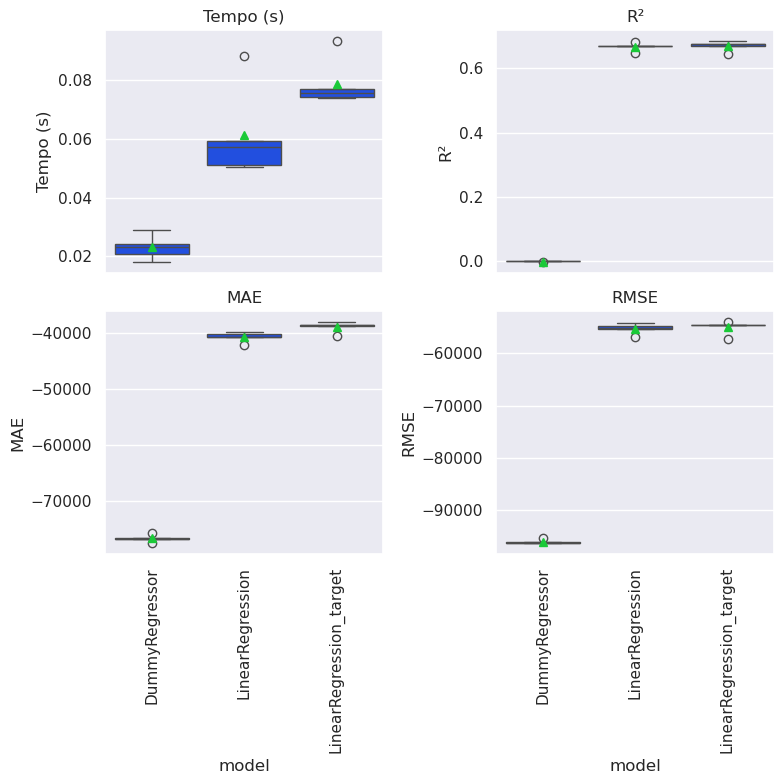

In [13]:
plot_comparar_metricas_modelos(df_resultados)

In [14]:
param_grid = {
    # transformer é um parametro da função sklearn.compose.TransformedTargetRegressor()
    'transformer': [None, PowerTransformer(), QuantileTransformer(output_distribution='normal')],
}

In [15]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    param_grid=param_grid,
    preprocessor=preprocessamento,
    target_transformer=target_transformer,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [16]:
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [17]:
grid_search.best_params_

{'transformer': QuantileTransformer(output_distribution='normal')}

In [18]:
grid_search.best_score_

np.float64(-54438.58043781144)

In [ ]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

coefs

,coeficiente
one_hot__ocean_proximity_INLAND,-0.447500
remainder__longitude,-0.294215
remainder__latitude,-0.287133
remainder__population_per_household,-0.280218
one_hot__ocean_proximity_NEAR BAY,-0.203195
one_hot__ocean_proximity_NEAR OCEAN,-0.057023
remainder__total_bedrooms,-0.000249
remainder__total_rooms,-0.000057
remainder__population,-0.000040
remainder__households,0.000876


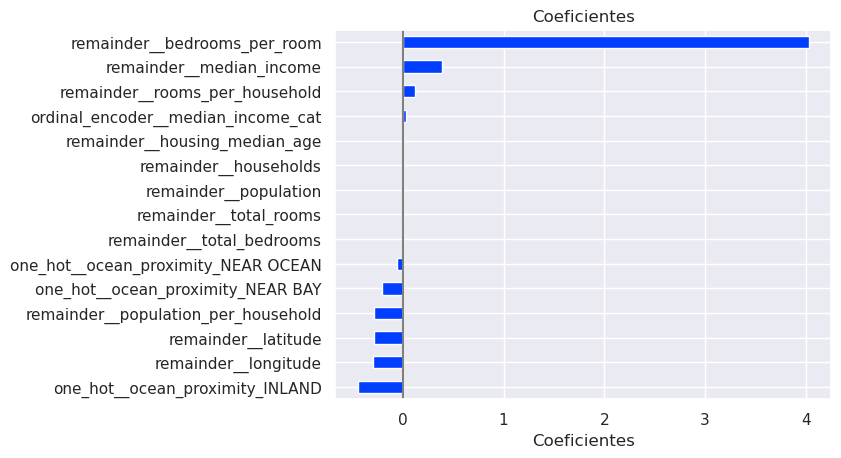

In [20]:
plot_coeficientes(coefs)

In [21]:
regressors = {
    'LinearRegression': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },

    'LinearRegression_target_power': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': target_transformer,
    },

    'LinearRegression_target_quantile': {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer_,
    },
}

In [22]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X=X, y=y, **regressor)
        for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,LinearRegression,0.04491,0.028726,0.682162,-39855.690921,-54254.958115,0.073636
1,LinearRegression,0.03549,0.012766,0.66999,-40272.565406,-54695.230224,0.048255
2,LinearRegression,0.037026,0.018551,0.649247,-42178.059246,-56955.988686,0.055578
3,LinearRegression,0.043335,0.01755,0.669873,-40806.492452,-55146.31876,0.060885
4,LinearRegression,0.046146,0.018507,0.669023,-40788.496555,-55331.351171,0.064653
5,LinearRegression_target_power,0.085258,0.018394,0.684232,-38127.990089,-54078.01827,0.103652
6,LinearRegression_target_power,0.077372,0.017018,0.671042,-38515.387176,-54607.941381,0.09439
7,LinearRegression_target_power,0.084995,0.019454,0.646094,-40531.127371,-57211.351363,0.104449
8,LinearRegression_target_power,0.08485,0.019616,0.677544,-38827.012941,-54501.880328,0.104466
9,LinearRegression_target_power,0.070979,0.021508,0.677014,-38544.774193,-54659.330513,0.092487


In [23]:
df_resultados.groupby('model').mean().T

model,LinearRegression,LinearRegression_target_power,LinearRegression_target_quantile
fit_time,0.041381,0.080691,0.086541
score_time,0.01922,0.019198,0.03953
test_r2,0.668059,0.671185,0.677956
test_neg_mean_absolute_error,-40780.260916,-38909.258354,-38683.895849
test_neg_root_mean_squared_error,-55276.769391,-55011.704371,-54442.602161
time_seconds,0.060602,0.099889,0.126071


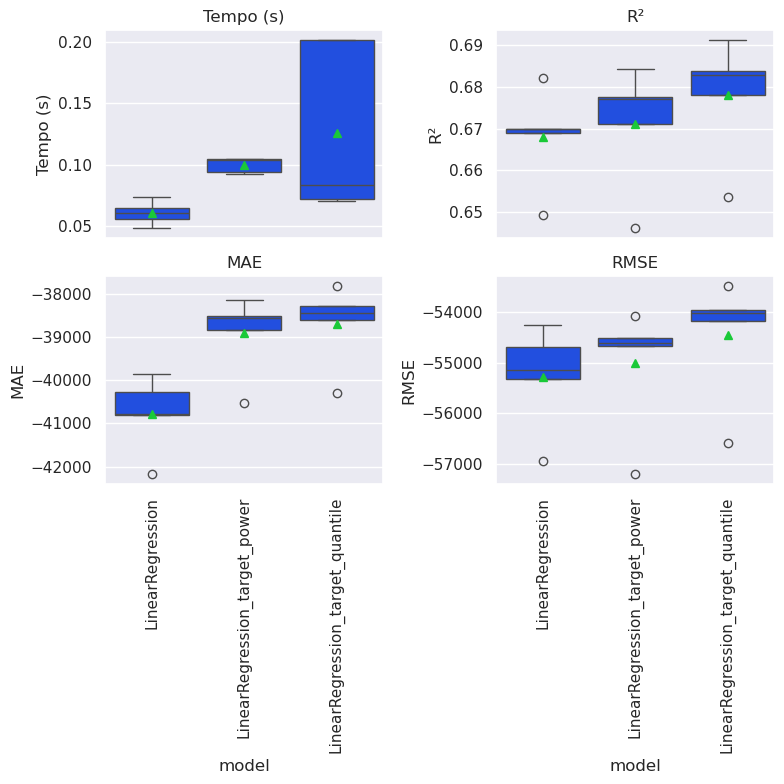

In [24]:
plot_comparar_metricas_modelos(df_resultados)

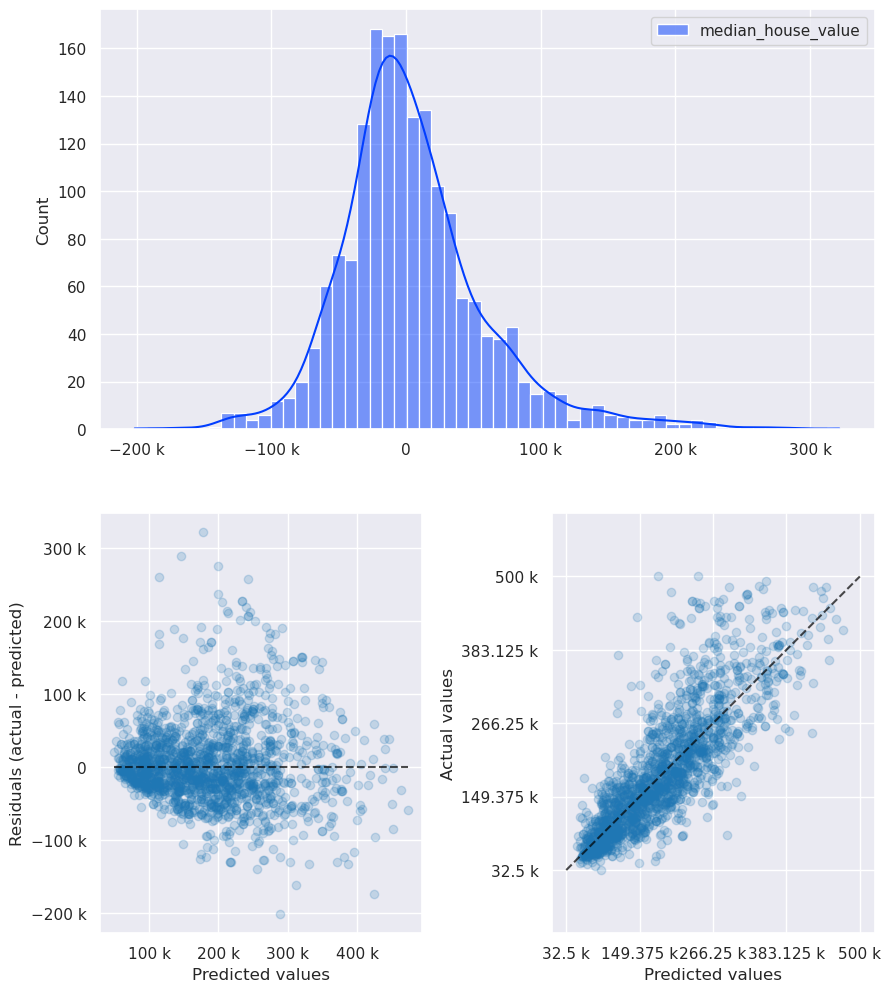

In [26]:
plot_residuos_estimador(
    estimator=grid_search.best_estimator_,
    X=X,
    y=y,
    eng_formatter=True,
    fracao_amostra=0.1,
)